In [3]:
import numpy as np
import pickle
import pandas as pd
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, rand, hp, Trials, tpe
from plotnine import *
import shap
rstate = np.random.default_rng(42)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
results_dir = "../../results"

## Loading training and test data:

In [52]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])
data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(105, 29)


(105, 36, 7)

In [5]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [6]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

indices_with_nan = nan_rows.index.tolist()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  


data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


In [7]:
data_combined = pd.concat([data_train,data_test])
data_combined.describe()

,PMID,Type,kcat,max_kcat_for_UID,MW_frac,max_kcat_for_RID,max_kcat_for_EC,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,log10_kcat
count,1.410000e+02,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,1.591142e+07,1.120567,12.208697,18.470882,1.071313,26.742490,35.084351,0.661838,0.570427,0.347082,-0.236791
std,5.066594e+06,0.326785,59.232340,66.858752,0.211246,68.586595,75.291376,0.371245,0.418368,0.373940,1.186609
min,7.876084e+06,1.000000,0.001667,0.001667,0.938065,0.004600,0.016100,0.015544,0.010497,0.010183,-2.778151
25%,1.195998e+07,1.000000,0.061167,0.085667,1.000000,0.100000,0.260000,0.353846,0.107962,0.037634,-1.213485
50%,1.474501e+07,1.000000,0.940000,2.250000,1.000597,2.743333,10.200000,0.839532,0.683230,0.147857,-0.026872
75%,1.714128e+07,1.000000,3.866667,10.200000,1.001091,21.323330,40.568330,1.000000,1.000000,0.651961,0.587337
max,2.973264e+07,2.000000,590.000000,590.000000,1.773738,590.000000,590.000000,1.000000,1.000000,1.000000,2.770852


In [8]:
data_val.describe()

,PMID,Type,kcat,max_kcat_for_UID,MW_frac,max_kcat_for_RID,max_kcat_for_EC,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,log10_kcat
count,7.000000e+00,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1.538038e+07,1.0,3.258095,3.936667,0.997652,40.986667,91.965238,0.881023,0.604173,0.660186,-0.115257
std,3.414882e+06,0.0,4.641071,5.564498,0.004315,87.575101,157.015004,0.172874,0.387255,0.446076,0.922018
min,1.115853e+07,1.0,0.075000,0.113333,0.993501,0.113333,0.113333,0.608333,0.030945,0.020668,-1.124939
25%,1.336737e+07,1.0,0.107500,0.113333,0.993501,0.113333,0.113333,0.779412,0.319721,0.351788,-0.969232
50%,1.518100e+07,1.0,0.883333,0.883333,0.997329,2.333333,0.883333,1.000000,0.661765,0.897059,-0.053875
75%,1.744234e+07,1.0,4.816667,7.166666,1.001433,24.166667,144.666666,1.000000,0.948530,1.000000,0.615650
max,1.970369e+07,1.0,12.000000,12.000000,1.002867,235.900000,353.200000,1.000000,1.000000,1.000000,1.079181


## 1. Training a model with enzyme and substrate information (ESM-2/GNN) + Temperature + pH:

#### (a) Creating input matrices:

In [9]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [10]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [11]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}


#### (c) Training and validating model:

In [12]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [13]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

[0.23501390284259893, 0.6904973066021485, -0.07018226390367785, -0.2760023292936854, -0.06052168251952153]
[3.9584923701919474, 13.297493166664964, 131.88502108850196, 29.456290746724875, 41.758638400927275]
[-0.323717335085528, -0.9137354327247675, -0.05694548840217206, -0.1563188959331674, -0.06626015482685643]
[2.8941198343669976, 9.846345316962646, 31.62598145900365, 11.964775582772178, 13.168707538564357]
[1.7477389705561501, 9.722153999403071, 0.4839738256799869, 2.955686487765321, 1.1864068304507647]


In [14]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

0.954 33.038913187 0.604 6.9854384884 0.0625312749


#### (d) Training model with test and train data for production mode:

In [15]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [16]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

(0.9998008429306383, 2.1686600260254683e-59) 9.579658949290302 0.9666910481571516


##### Validating model

In [17]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [18]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_gnn_fp.npy"), 'wb') as f:
    np.save(f, val_Y)

(-0.2649411230767653, 0.5658401658544749) 5.141653989620619 -0.431911152476375 3.703173276522141 1.806487802740822


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [19]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [20]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [21]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [22]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [23]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

[0.3744479762107584, 0.4863456288299669, -0.12271420643618748, 0.15308251908615017, 0.02972832982538952]
[4.69671694676507, 13.347518787752398, 131.94783521231383, 28.453145896249957, 41.400417837564056]
[-0.8634785896867001, -0.9281615930679064, -0.057952530969734184, -0.07890222442443195, -0.048045095674679406]
[3.3906450142656586, 10.043408411571216, 32.32320089839727, 11.414140114849324, 11.484677298395493]
[3.206762759435849, 9.75448089572055, 1.4389797951913907, 2.1893239740234063, 1.079610084008782]


In [24]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

0.78 46.3734249518 0.219 8.8215887697 0.0602869217


#### (d) Training model with test and train data for production mode:

In [25]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

[('f242', 203.44760131835938), ('f1025', 99.47826385498047), ('f602', 38.49742889404297), ('f853', 29.858318328857422), ('f1066', 22.262493133544922), ('f1028', 20.206832885742188), ('f3131', 17.43523406982422), ('f1088', 12.626955032348633), ('f3329', 12.29869270324707), ('f593', 11.588397026062012), ('f3023', 9.825798034667969), ('f2950', 9.544332504272461), ('f28', 8.231653213500977), ('f1082', 7.124903678894043), ('f813', 6.682524681091309), ('f1036', 6.433215141296387), ('f1228', 4.886631011962891), ('f1184', 4.282169342041016), ('f1177', 4.138988971710205), ('f792', 4.077589988708496), ('f1470', 3.860812187194824), ('f135', 3.706883668899536), ('f1654', 3.4651429653167725), ('f4', 3.4089746475219727), ('f1205', 3.3597724437713623), ('f275', 3.0553297996520996), ('f1053', 2.979145050048828), ('f829', 2.9028968811035156), ('f1267', 2.8540804386138916), ('f1111', 2.6853485107421875)]


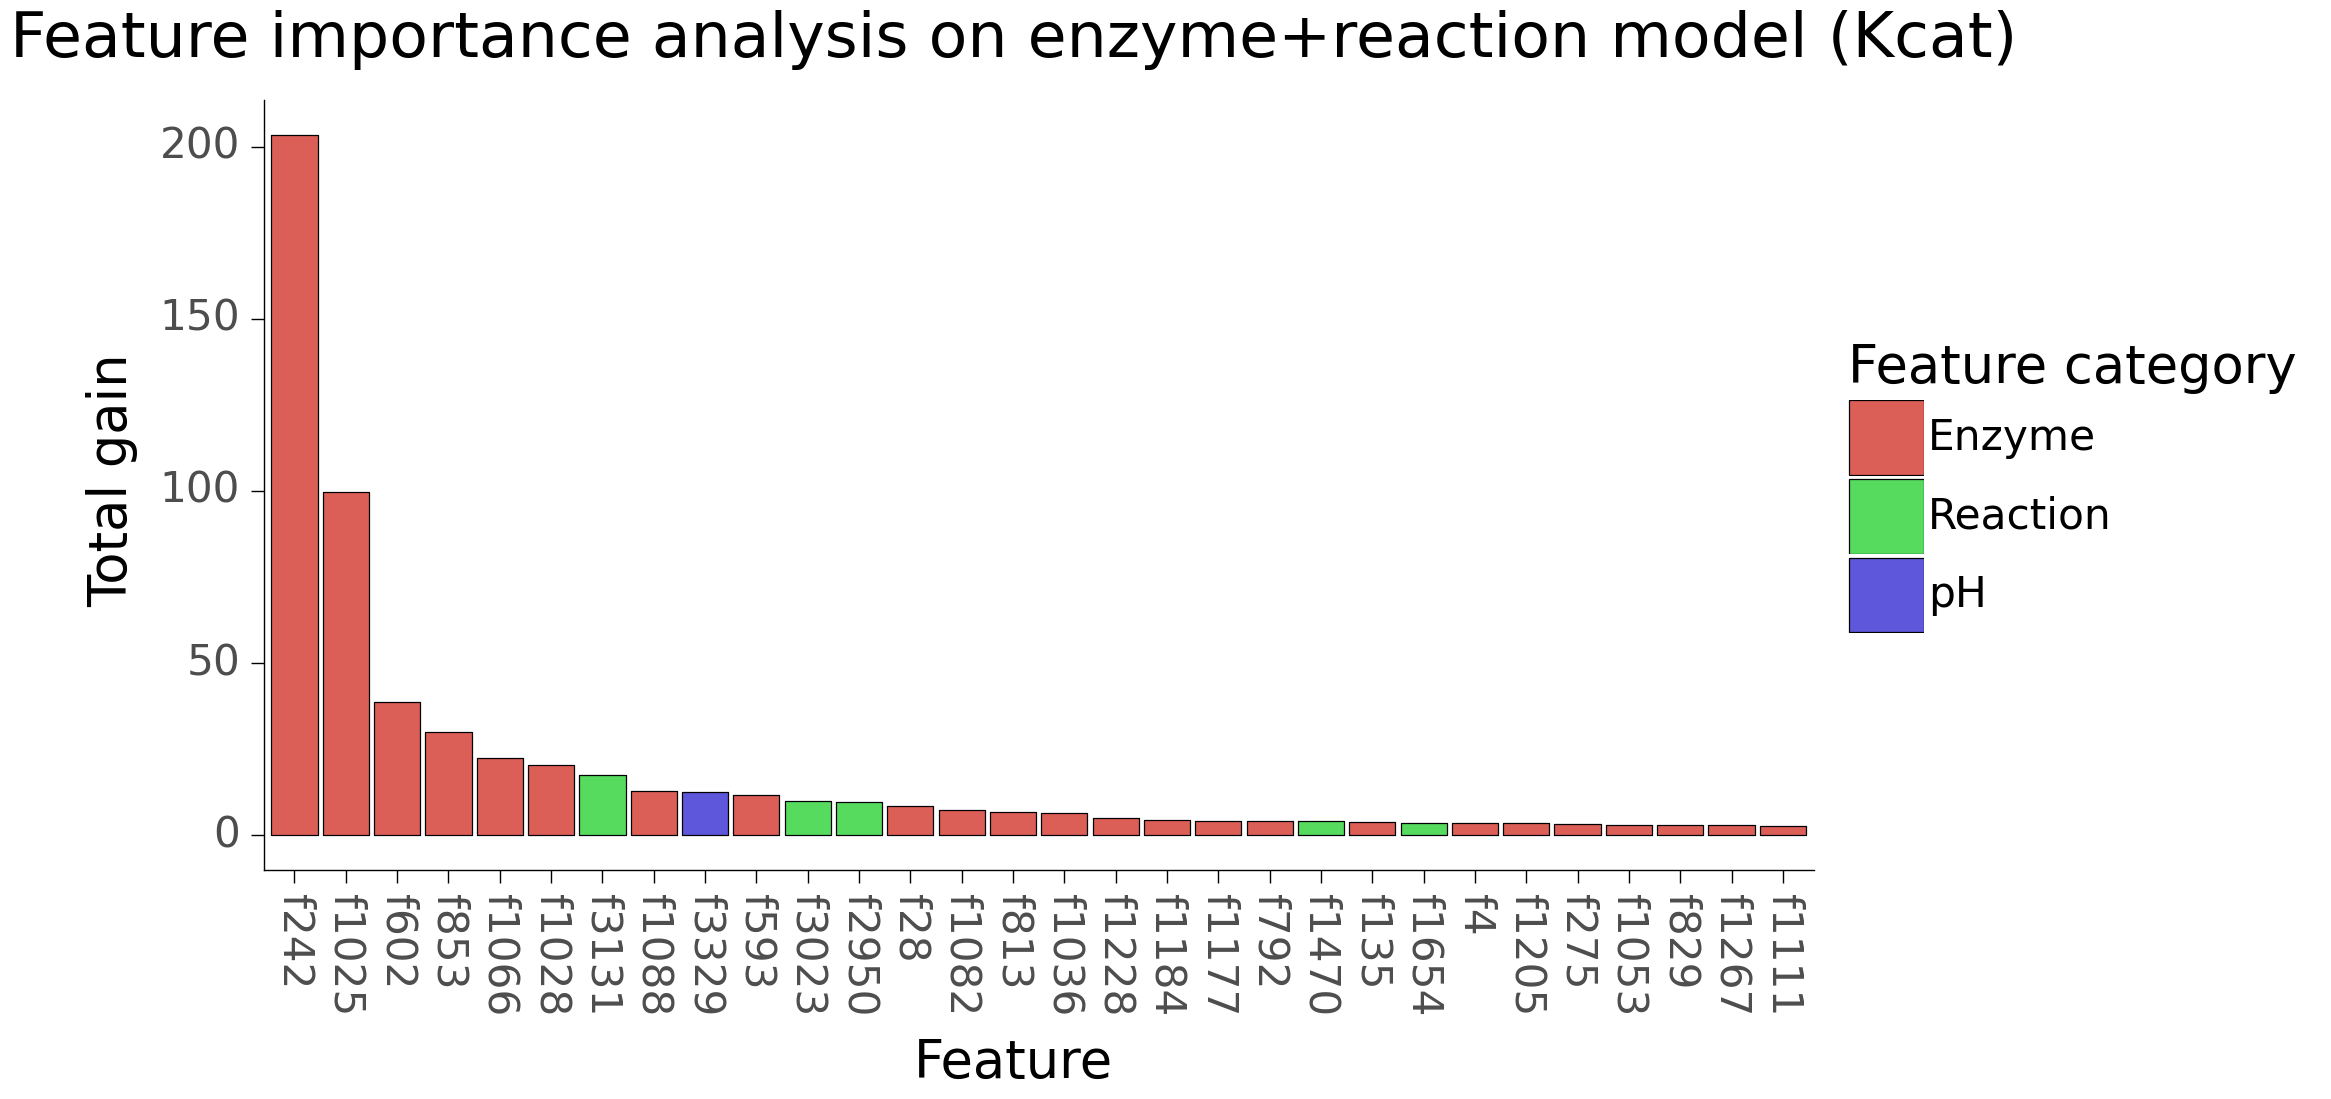

<ggplot: (-9223371914600496448)>

In [26]:
importances = bst.get_score(importance_type="total_gain")
listy = list(importances.items())
sorted_itESM = sorted(listy, key=lambda x: x[1], reverse=True)[:30]
print(sorted_itESM)
dicti = dict(sorted_itESM)
importances = pd.DataFrame({'Feature' : dicti.keys(), "Importance" : dicti.values()})
def condition(x):
    if int(x[1:]) <= 1279:
        return "Enzyme"
    elif 1279 <= int(x[1:]) <= 3327:
        return "Reaction"
    elif int(x[1:]) == 3328:
        return 'Temperature'
    else : 
        return 'pH'
importances["Feature category"] = importances["Feature"].apply(condition)
importances_order = importances.sort_values(by='Importance', ascending=False)["Feature"]
(ggplot(importances, aes(x="Feature", y="Importance", fill="Feature category"))
+ geom_bar(stat="identity", width=0.9, color='black')
+ scale_x_discrete(limits= importances_order)
+ labs(title="Feature importance analysis on enzyme+reaction model (Kcat)", y = "Total gain")
+ theme_classic(base_size=38)
+ theme(figure_size=(20, 10), axis_text_x=element_text(angle=-90), plot_title = element_text(ha = "center"))
)

##### Validating model

In [27]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [28]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_diff_fp.npy"), 'wb') as f:
    np.save(f, val_Y)

(0.3517610094891535, 0.4390812898892313) 4.170513174683065 0.05791655493634784 3.3591704909005093 2.6595720855337714


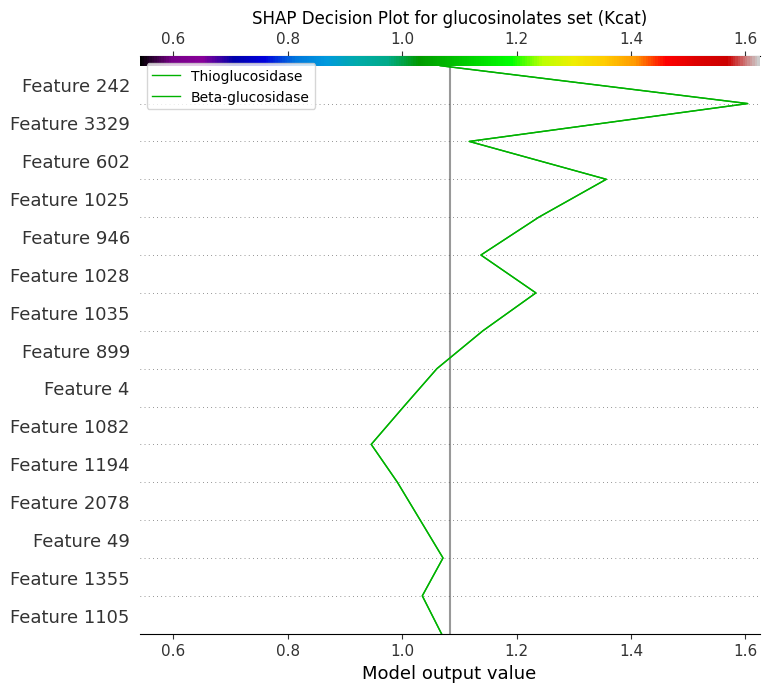

In [29]:
explainer = shap.TreeExplainer(bst)
explanation = explainer(10**val_X)

shap_values = explanation.values
shap_interaction_values = explainer.shap_interaction_values(val_X)
np.abs(shap_values.sum(axis=1) + explanation.base_values - 10**y_val_pred).max()
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
shap.decision_plot(10**explainer.expected_value, shap_values[2:4], legend_labels=["Thioglucosidase", "Beta-glucosidase"], plot_color="nipy_spectral", features=10**val_X[2:4],
                    feature_display_range=slice(-1, -16, -1), title = "SHAP Decision Plot for glucosinolates set (Kcat)", legend_location = "upper left")
plt.show()

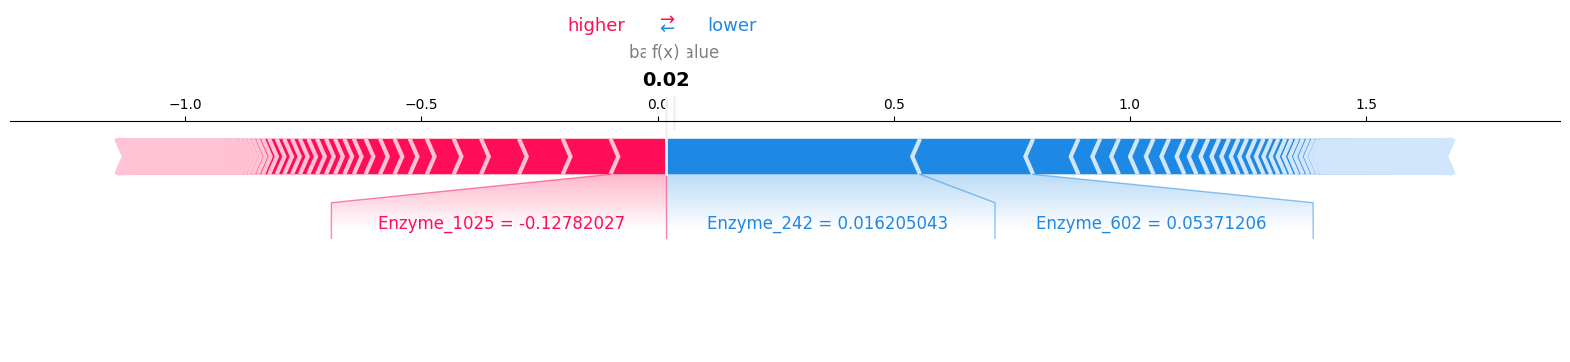

In [30]:
names = list()
for i in range(0, 1279):
    names.append("Enzyme_%s" %str(i))

for i in range(0, 2047):
    names.append("Reaction_%s" %str(i))

names.append(["Temperature", "pH"])

shap.force_plot(explainer.expected_value, shap_values[2], val_X[2], matplotlib=True, feature_names=names, text_rotation=0)

In [31]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

(0.999626425095693, 9.543606304321644e-55) 10.84357034221046 0.9573218610339533


In [32]:
with open(join(results_dir, split, "xgboost_ESM2_diff_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

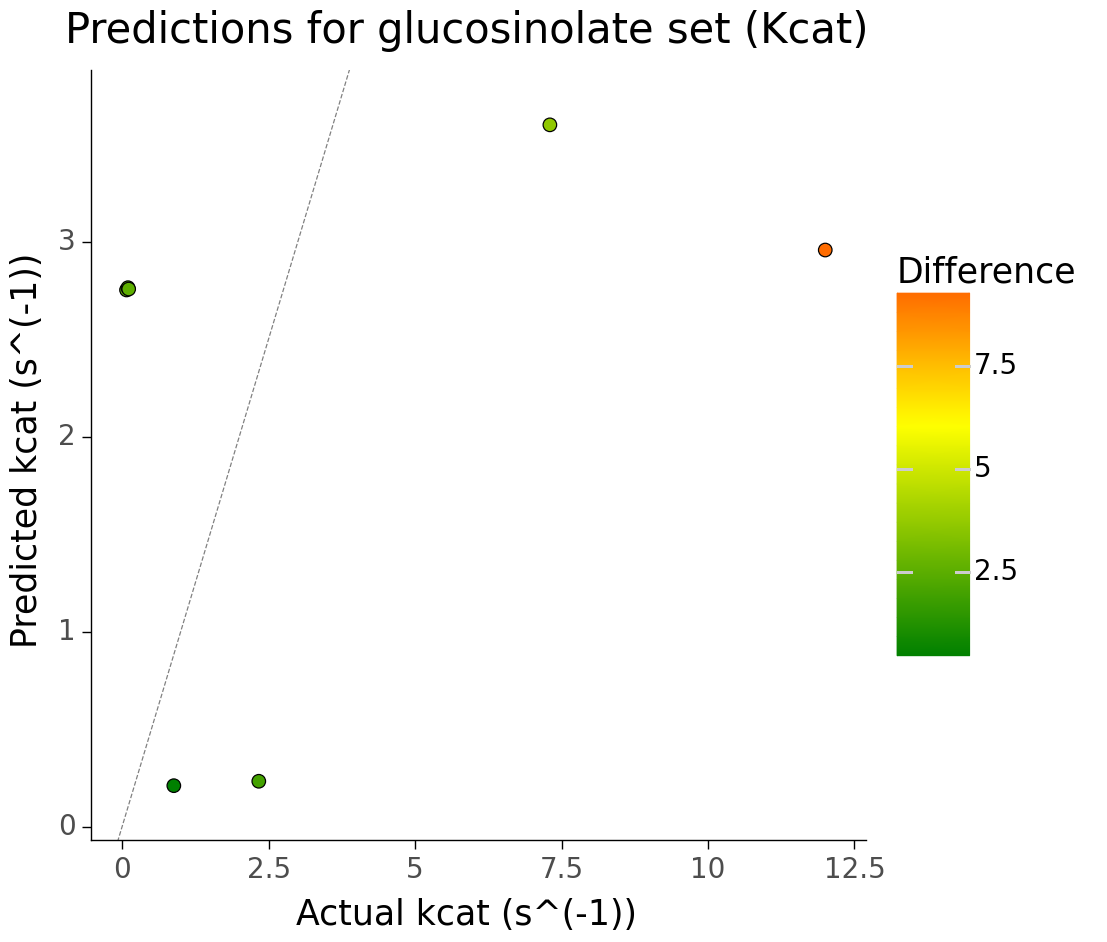

<ggplot: (-9223371914696752104)>

In [33]:
predictions = pd.DataFrame({"Actual kcat": [10**x for x in val_Y], "Predicted kcat" : [10**x for x in y_val_pred], "Difference" : abs(np.array([10**x for x in val_Y])-np.array([10**x for x in y_val_pred]))})

(
    ggplot(predictions, aes(x = "Actual kcat", y="Predicted kcat", fill="Difference"))
    + geom_point(color="black", size=5, position = position_jitter(width = 0.0015)) 
    + geom_abline(slope = 1, intercept = 0, color = "grey", linetype="dashed")
    + scale_fill_gradient2(low = "green", mid="yellow", high = "red", midpoint=6)
    + labs(title="Predictions for glucosinolate set (Kcat)", x="Actual kcat (s^(-1))", y="Predicted kcat (s^(-1))", fill="Difference")
    + theme_classic(base_size=25)
    + xlim(min(predictions["Actual kcat"]), max(predictions["Actual kcat"]+0.1))
    + ylim(min(predictions["Predicted kcat"]-0.1), max(predictions["Predicted kcat"]+0.1))
    + theme(figure_size=(10, 10))
)

In [34]:
with open(join(results_dir, split, "xgboost_ESM2_gnn_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

## 3. Training a model with enzyme, substrate (GNN fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [35]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [36]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [37]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [38]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [39]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

[0.595093495471497, 0.3770873269118614, -0.10271879619312088, -0.04317444809836638, -0.10105529637402483]
[2.8048848391263315, 13.288576887005195, 131.8840992336321, 28.93302412052766, 42.043729361887515]
[0.3353917898708817, -0.9111698845579033, -0.056930712699331476, -0.11560169429029488, -0.0808688106972586]
[2.0277971306503586, 9.690249879115727, 32.12050358182761, 12.31564398355763, 12.284343942145721]
[1.6677132877337515, 9.733084814264004, 1.1252410483486783, 3.358644398064844, 1.1175453503439572]


In [40]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

0.968 28.8290104576 0.698 6.3474243759 0.0420167093


#### (d) Training model with test and train data for production mode:

In [41]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [42]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

(0.9998894632120197, 9.767225602656046e-64) 6.943068176289562 0.9825029944101197


In [43]:
with open(join(results_dir, split, "xgboost_ESM2_gnn_fp_diff_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

In [44]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [45]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, val_Y)

(-0.38225083347318695, 0.397422217662461) 4.8341194352659995 -0.2657418205911737 3.605257043250575 2.1127105985584644


## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [46]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [47]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [48]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 250.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [49]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [50]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join("..", "..", "data", split, "R2_CV_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, np.array(R2))

[0.25632931264171993, 0.5752235139025781, -0.10104256914693022, -0.24135731243204087, 0.07395880419386214]
[4.639047320246003, 13.463468270427134, 131.93125992705737, 29.483199885506124, 41.15118957888805]
[-0.8179973129291203, -0.9618068589432924, -0.05768674769965809, -0.15843251970004246, -0.035464727864746415]
[3.463862023807774, 9.879165095594105, 31.791465657874777, 11.378863572109994, 11.595003771809337]
[2.3048229867281713, 9.66825853592817, 1.094072389762641, 0.9711974520088072, 1.3442002034309788]


FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\secondary\\Pearson_CV_xgboost_ESM2.npy'

In [51]:
import os
os.getcwd()

'C:\\Users\\jearle\\Desktop\\PhD files that I dont want to be backuped constantly\\kin_consts_pred\\Enkyme\\Kcat\\code\\modelling'

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, test_Y)

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

In [ ]:
with open(join(results_dir, split, "xgboost_ESM2.pkl"), 'wb') as f:
    pickle.dump(bst, f)

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_ESM2.npy"), 'wb') as f:
    np.save(f, val_Y)

## 5. Training a model with main substrate information (GNN) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 100, 'reg_alpha': 1.0, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

In [ ]:
with open(join(results_dir, split, "xgboost_gnn_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)


MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_gnn_fp.npy"), 'wb') as f:
    np.save(f, val_Y)

## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 7.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42,'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

In [ ]:
with open(join(results_dir, split, "xgboost_diff_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)


MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_diff_fp.npy"), 'wb') as f:
    np.save(f, val_Y)

## 7. Training a model with reaction and main substrate information (diff-fp/GNN) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

with open(join(results_dir, split, "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(Pearson))
with open(join(results_dir, split, "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(MSE))
with open(join(results_dir, split, "R2_CV_xgboost_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

with open(join(results_dir, split, "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, bst.predict(dtest))
with open(join(results_dir, split, "y_test_true_xgboost_gnn_fp_diff_fp.npy"), 'wb') as f:
    np.save(f, test_Y)

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X,  np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

In [ ]:
with open(join(results_dir, split, "xgboost_gnn_fp_diff_fp.pkl"), 'wb') as f:
    pickle.dump(bst, f)

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X,  np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

with open(join(results_dir, split, "y_test_pred_xgboost_diff_fp_gnn_fp.npy"), 'wb') as f:
    np.save(f, y_val_pred)
with open(join(results_dir, split, "y_test_true_xgboost_diff_fp_gnn_fp.npy"), 'wb') as f:
    np.save(f, val_Y)